# Actor-critic model for Pendulum

## Imports

In [1]:
import gym
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers.merge import Add, Multiply
from keras.optimizers import Adam
import keras.backend as K

import tensorflow as tf

import random

from collections import deque

# Imports specifically so we can render outputs in Jupyter.
import matplotlib.pyplot as plt
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

Using TensorFlow backend.


## Utils functions (display)

In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

## Class ActorCritic

Determines how to assign values to each state, i.e. takes the state and action (two-input model) and determines the corresponding value

In [3]:
class ActorCritic:
    def __init__(self, env, sess):
        self.env = env
        self.sess = sess
        
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = .995
        self.gamma = .95
        self.tau = .125
        
        #Actor model - Chain rule
        #Calculate de/dA as = de/dC * dC/dA, where e is error, C critic, A actor
        self.memory = deque(maxlen=2000)
        self.actor_state_input, self.actor_model = self.create_actor_model()
        _, self.target_actor_model = self.create_actor_model()
        
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.env.action_space.shape[0]]) #Feed de/dC from Critic
        actor_model_weights = self.actor_model.trainable_weights
        self.actor_grads = tf.gradients(self.actor_model.output, actor_model_weights, -self.actor_critic_grad) #dC/dA from Act
        grads = zip(self.actor_grads, actor_model_weights)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)
        
        #Critic model
        
        self.critic_state_input, self.critic_action_input, self.critic_model = self.create_critic_model()
        _, _, self.target_critic_model = self.create_critic_model()
        
        self.critic_grads = tf.gradients(self.critic_model.output, self.critic_action_input) #Where we calculate de/dC
        
        #Initialize for later gradient calculations
        self.sess.run(tf.global_variables_initializer())
        
    
    #MODEL DEFINITIONS
    def create_actor_model(self):
        state_input = Input(shape=self.env.observation_space.shape)
        h1 = Dense(24, activation='relu')(state_input)
        h2 = Dense(48, activation='relu')(h1)
        h3 = Dense(24, activation='relu')(h2)
        output = Dense(self.env.action_space.shape[0], activation='relu')(h3)
        
        model = Model(inputs=state_input, outputs=output)
        adam = Adam(lr=0.001)
        model.compile(loss='mse',optimizer=adam)
        return state_input, model
    
    def create_critic_model(self):
        state_input = Input(shape=self.env.observation_space.shape)
        state_h1 = Dense(24, activation='relu')(state_input)
        state_h2 = Dense(48)(state_h1)
        
        action_input = Input(shape=self.env.action_space.shape)
        action_h1 = Dense(48)(action_input)
        
        merged = Add()([state_h2, action_h1])
        merged_h1 = Dense(24, activation='relu')(merged)
        output = Dense(1, activation='relu')(merged_h1)
        model = Model(inputs=[state_input, action_input], outputs=output)
        
        adam = Adam(lr=0.001)
        model.compile(loss='mse', optimizer=adam)
        return state_input, action_input, model
    
    #MODEL TRAINING
    def remember(self, cur_state, action, reward, new_state, done):
        self.memory.append([cur_state, action, reward, new_state, done])
        
        
    def _train_actor(self, samples):
        for sample in samples:
            cur_state, action, reward, new_state, _ = sample
            predicted_action = self.actor_model.predict(cur_state)
            feed = {self.critic_state_input: cur_state, self.critic_action_input: predicted_action}
            grads = self.sess.run(self.critic_grads, feed_dict=feed)[0]
            
            self.sess.run(self.optimize, feed_dict = {self.actor_state_input: cur_state, self.actor_critic_grad: grads})
            
            
    def _train_critic(self, samples):
        for sample in samples:
            cur_state, action, reward, new_state, done = sample
            
            if not done:
                target_action = self.target_actor_model.predict(new_state)
                future_reward = self.target_critic_model.predict([new_state, target_action])[0][0]
                reward += self.gamma * future_reward
            
            self.critic_model.fit([cur_state, action], reward, verbose=0)
            
            
    def train(self):
        batch_size = 32
        if(len(self.memory) < batch_size):
            return
        
        rewards = []
        samples = random.sample(self.memory, batch_size)
        self._train_critic(samples)
        self._train_actor(samples)
        
        
    #TARGET MODEL UPDATING
    def _update_actor_target(self):
        actor_model_weights = self.actor_model.get_weights()
        actor_target_weights = self.target_critic_model.get_weights()
        
        for i in range(len(actor_target_weights)):
            actor_target_weights[i] = actor_model_weights[i]
        self.target_critic_model.set_weights(actor_target_weights)
        
        
    def _update_critic_target(self):
        critic_model_weights = self.critic_model.get_weights()
        critic_target_weights = self.critic_target_model.get_weights()
        
        for i in range(len(critic_target_weights)):
            critic_target_weights[i] = critic_model_weights[i]
        self.critic_target_model.set_weights(critic_target_weights)
        
    def update_target(self):
        self._update_actor_target()
        self._update_critic_target()
        
        
    #MODEL PREDICTIONS
    
    def act(self, cur_state):
        self.epsilon *= self.epsilon_decay
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return self.actor_model.predict(cur_state)    

## Train function

In [4]:
def train(env,num_trials=100,render=False):
    sess = tf.Session()
    K.set_session(sess)
    actor_critic = ActorCritic(env, sess)
    
    #Initialize environment
    cur_state = env.reset()
    action = env.action_space.sample()
    
    frames = []
        
    display_freq = num_trials//10
    i = 0
    while True:
        if(i % display_freq == 0):
            print('At trial %d' % i)
        if render:
            frames.append(env.render(mode = 'rgb_array'))
        
        cur_state = cur_state.reshape((1,env.observation_space.shape[0]))
        action = actor_critic.act(cur_state)
        action = action.reshape((1, env.action_space.shape[0]))
        
        new_state, reward, done, _ = env.step(action)
        new_state = new_state.reshape((1, env.observation_space.shape[0]))
        
        actor_critic.remember(cur_state, action, reward, new_state, done)
        actor_critic.train()
        
        cur_state = new_state
        i+=1
        
        if(i == num_trials):
            break
        
    if render:
        env.render(close=True)
        display_frames_as_gif(frames)

## Hyperparams 

In [8]:
num_trials = 100
trial_len = 500

## Environment

In [9]:
env = gym.make("Pendulum-v0")

[2017-12-16 15:08:01,733] Making new env: Pendulum-v0


At trial 0
At trial 10
At trial 20
At trial 30
At trial 40
At trial 50
At trial 60
At trial 70
At trial 80
At trial 90



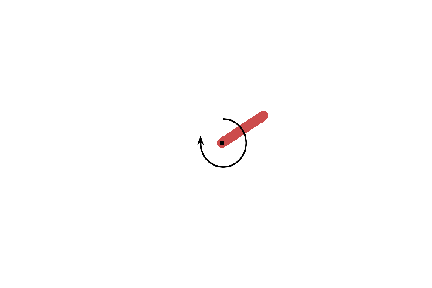
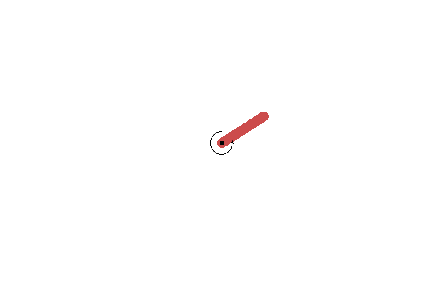
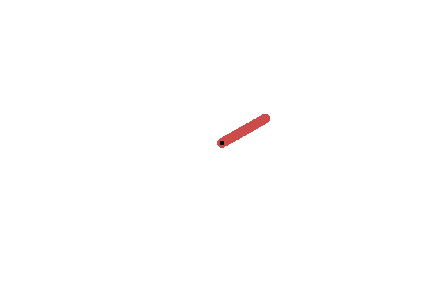
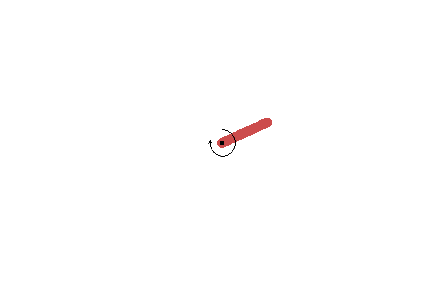
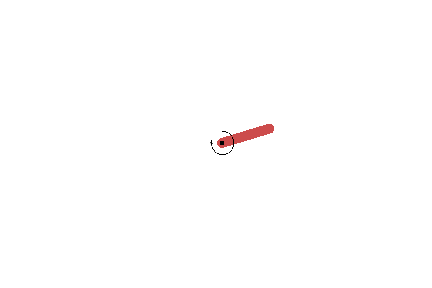
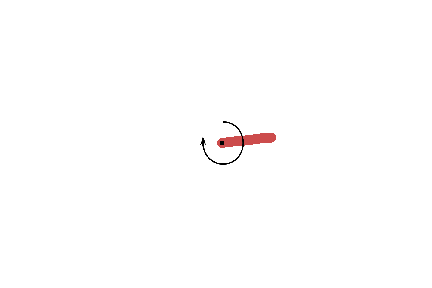
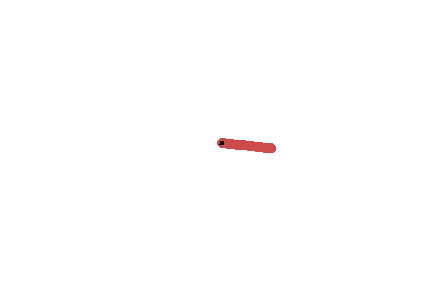
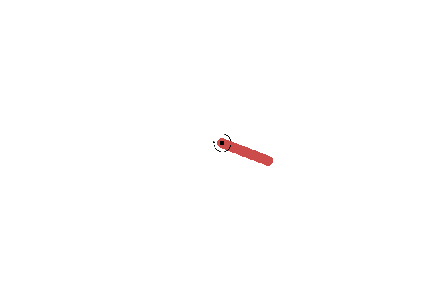
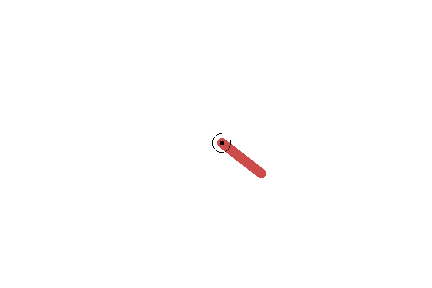
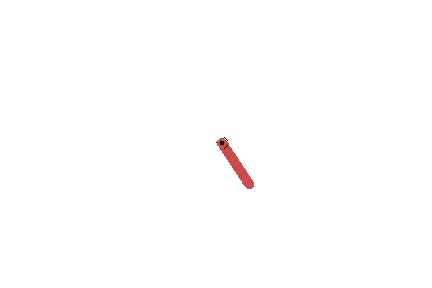
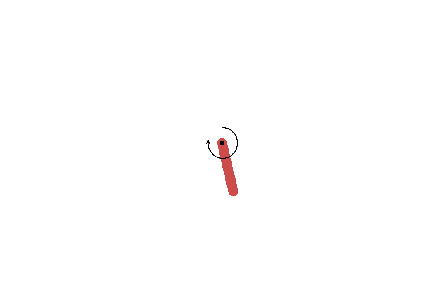
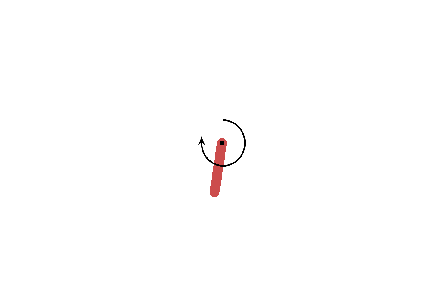
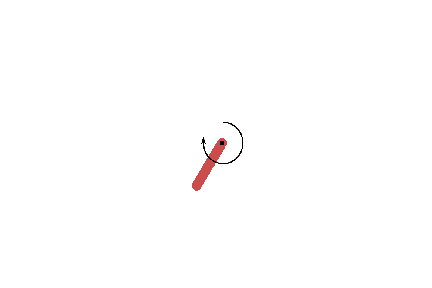
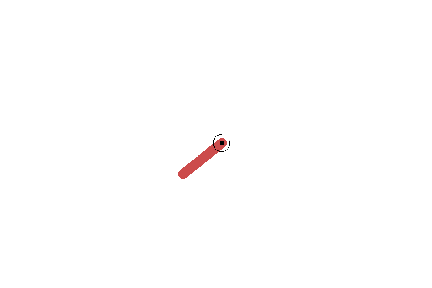
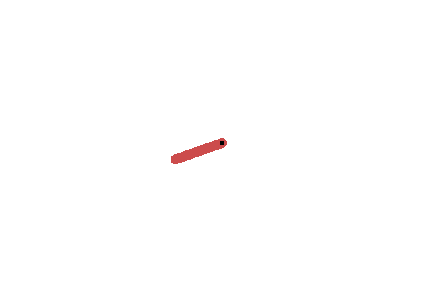
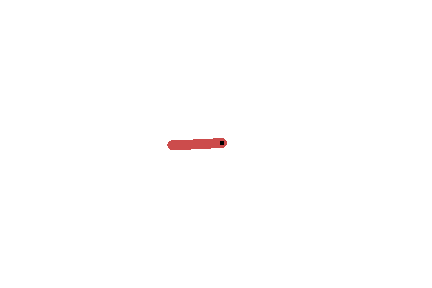
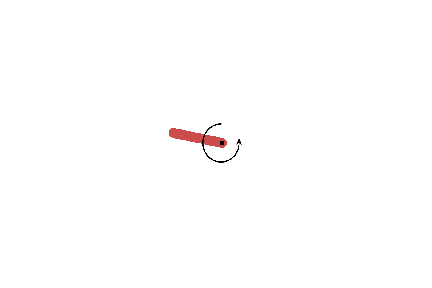
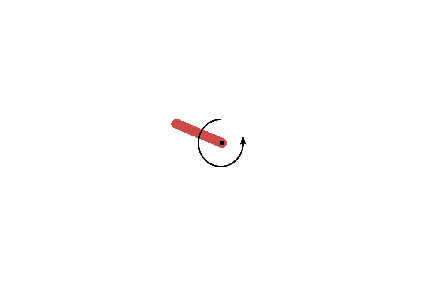
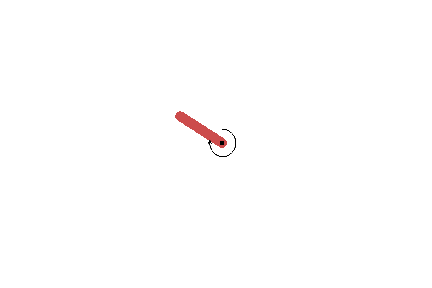
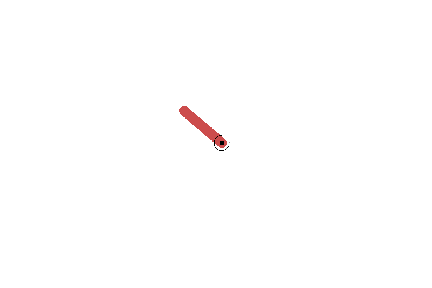
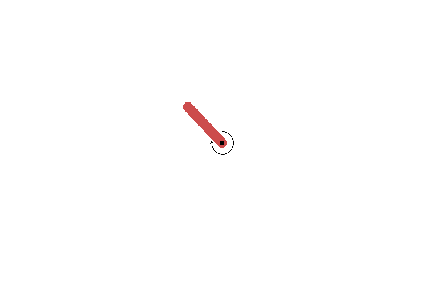
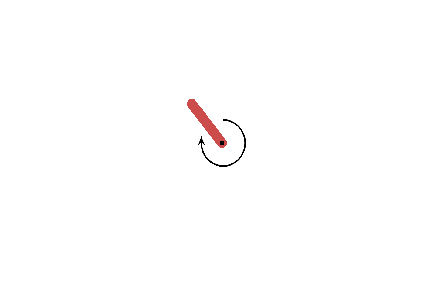
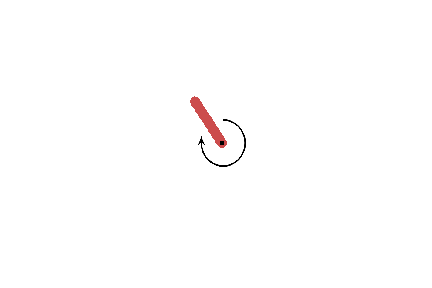
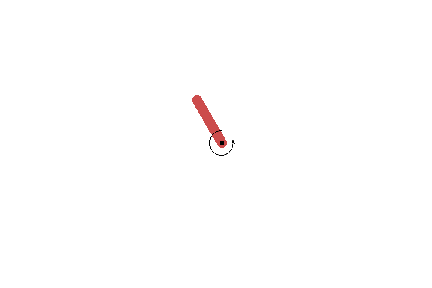
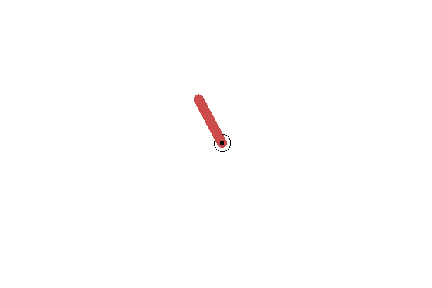
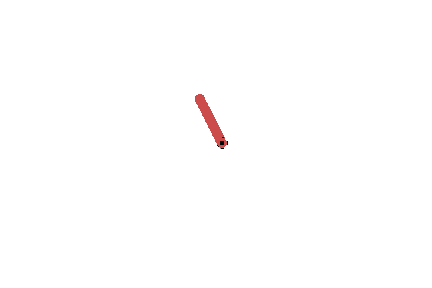
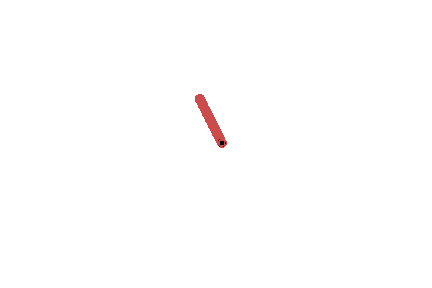
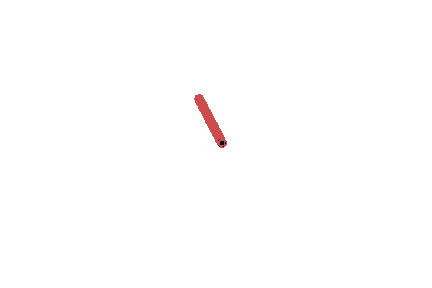
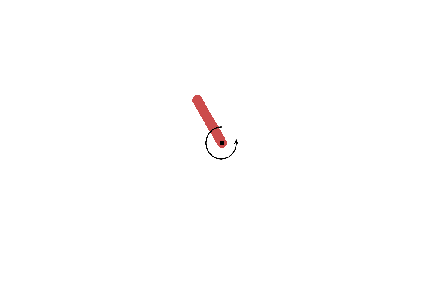
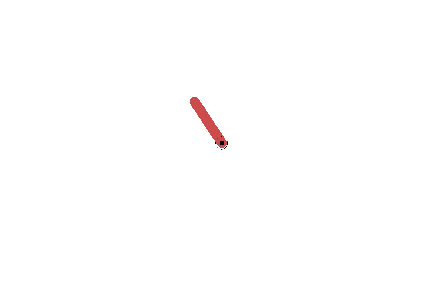
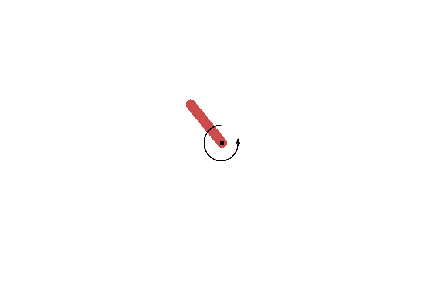
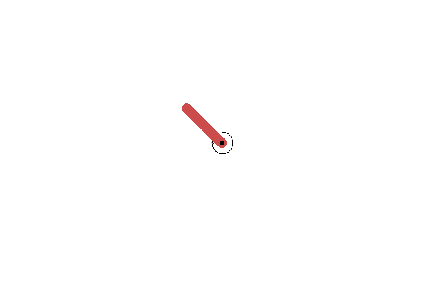
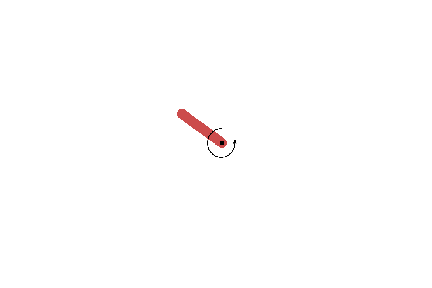
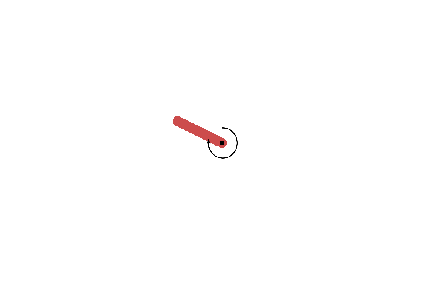
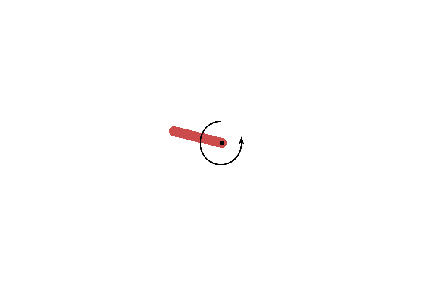
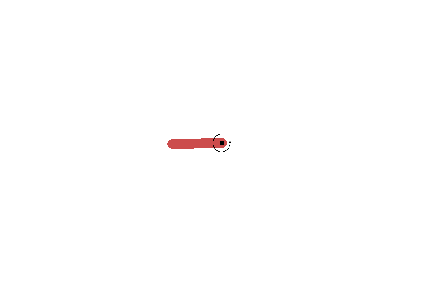
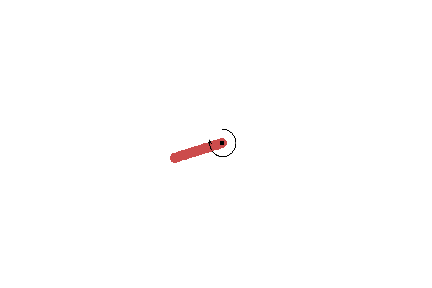
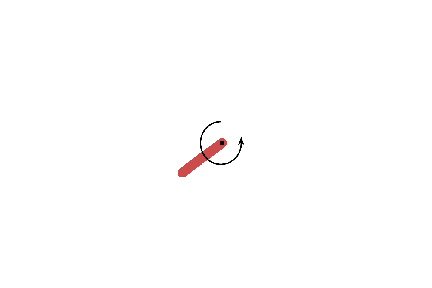
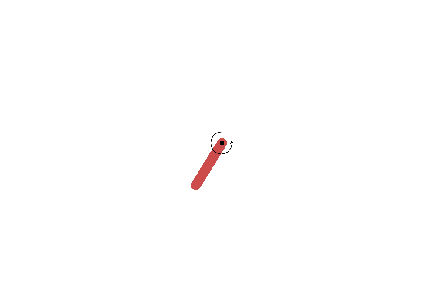
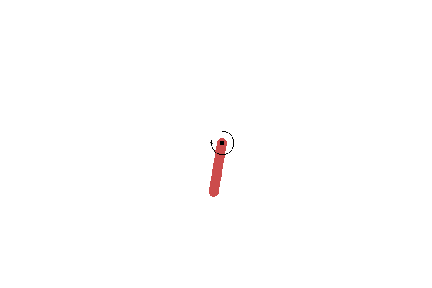
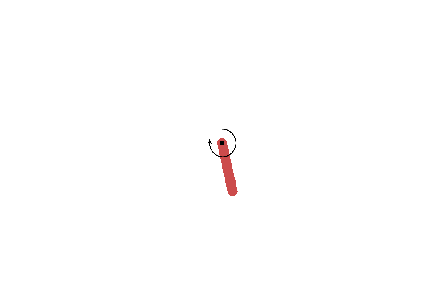
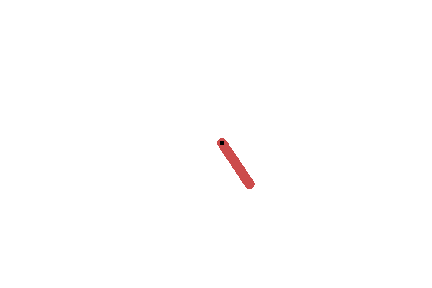
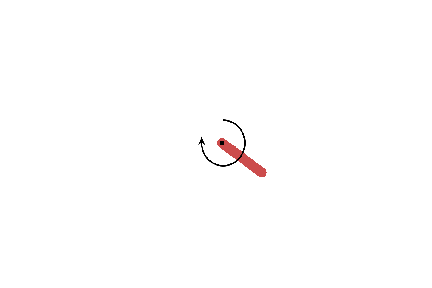
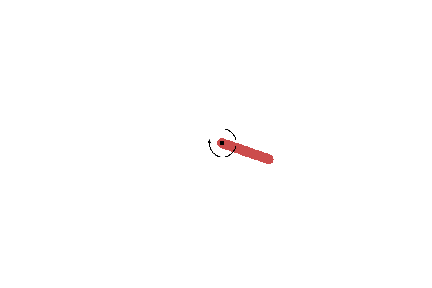
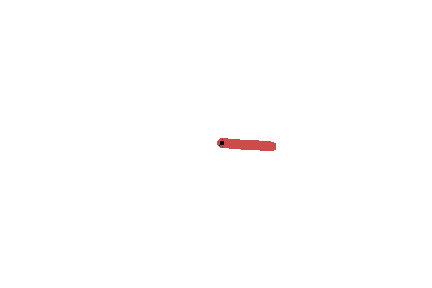
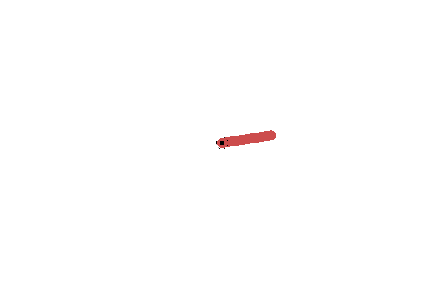
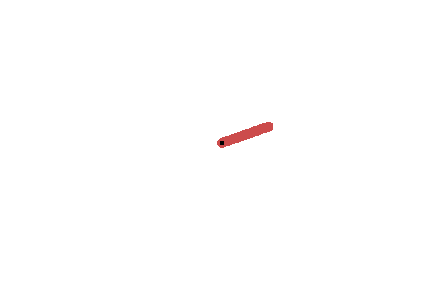
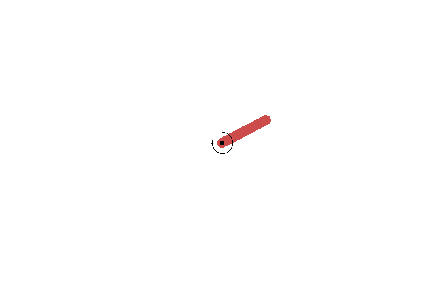
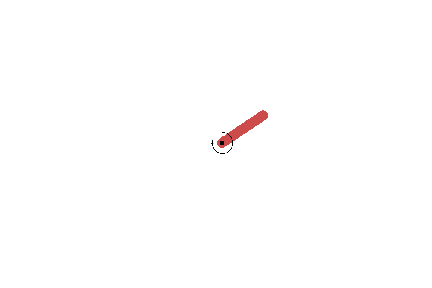
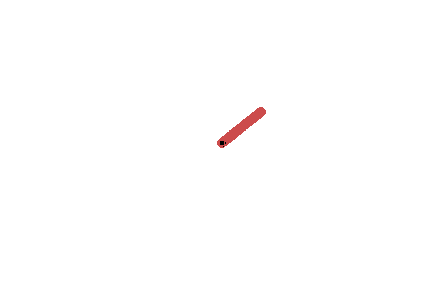
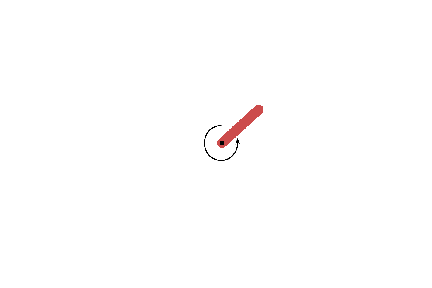
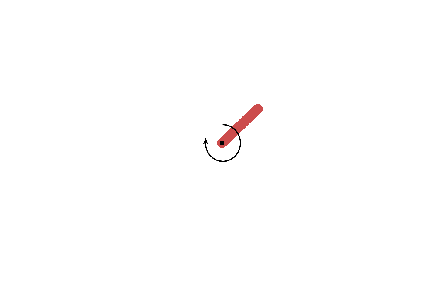
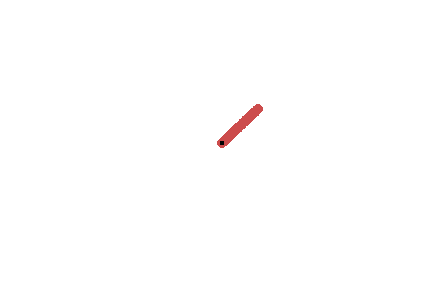
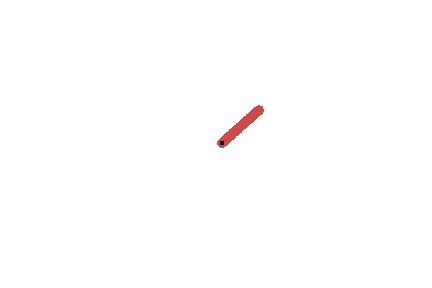
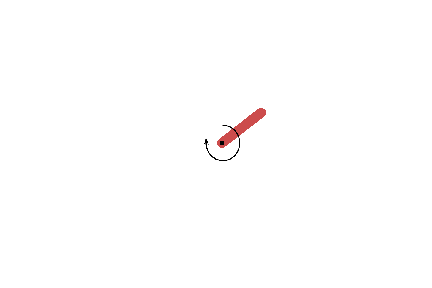
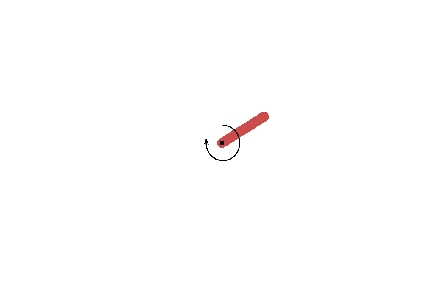
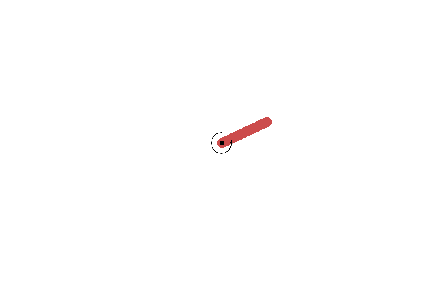
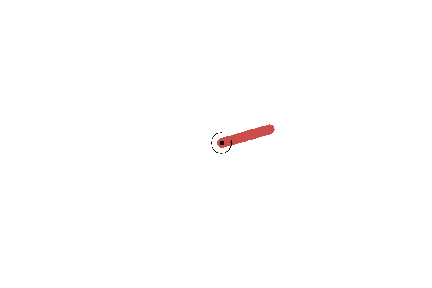
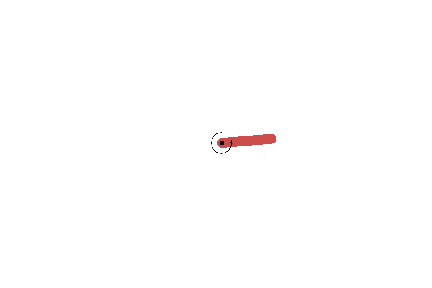
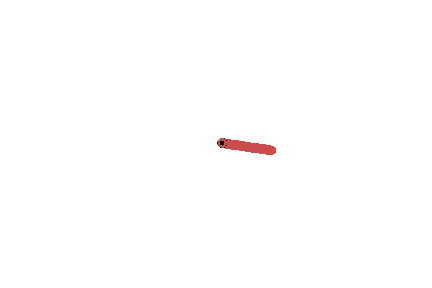
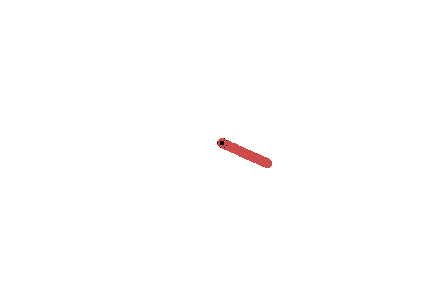
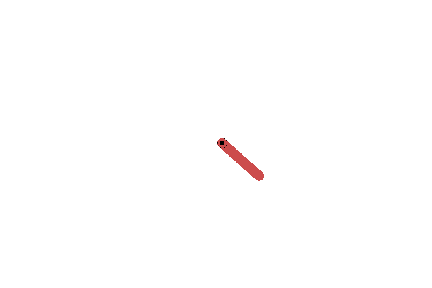
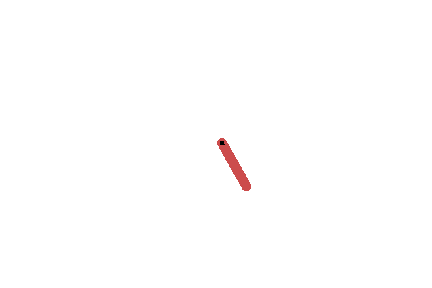
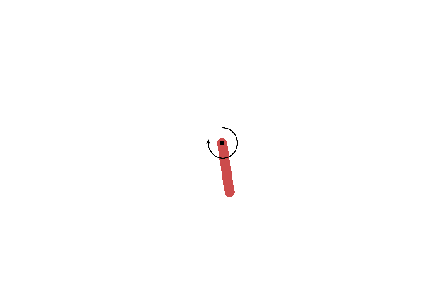
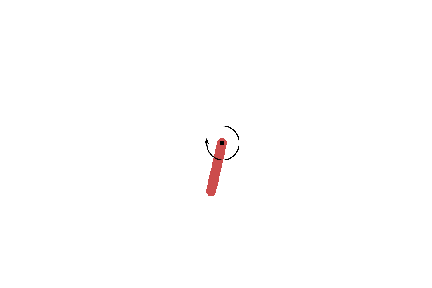
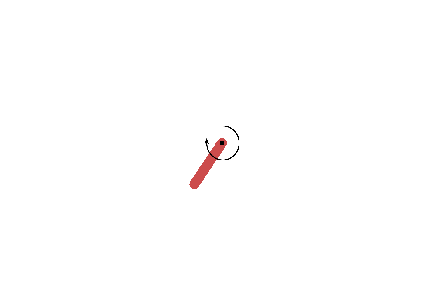
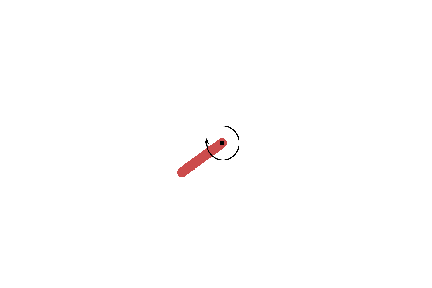
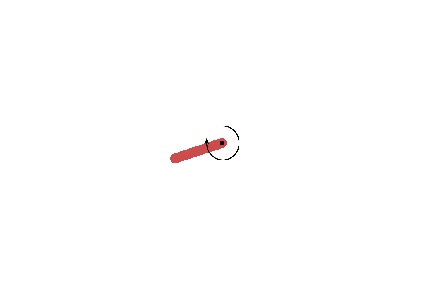
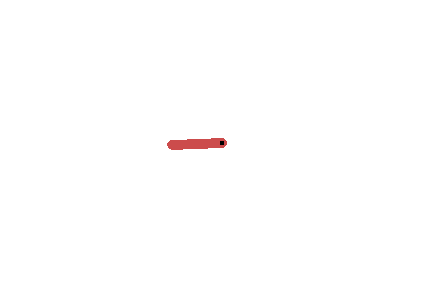
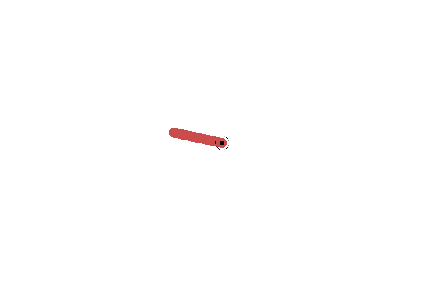
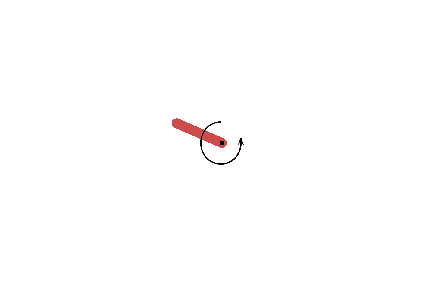
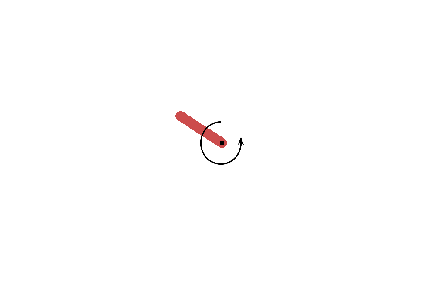
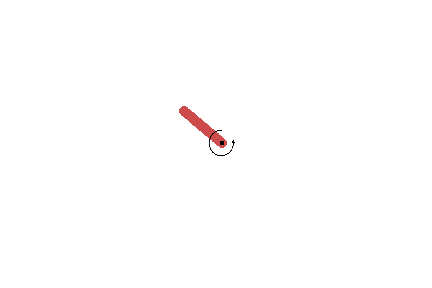
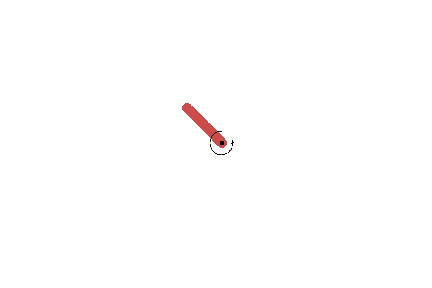
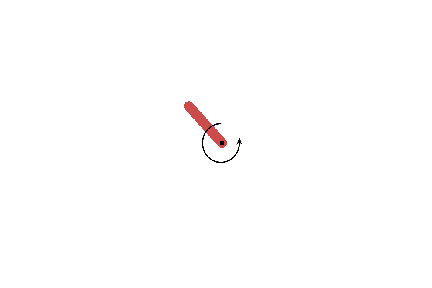
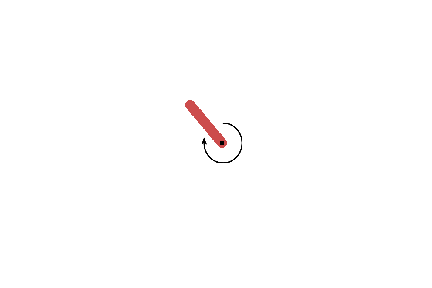
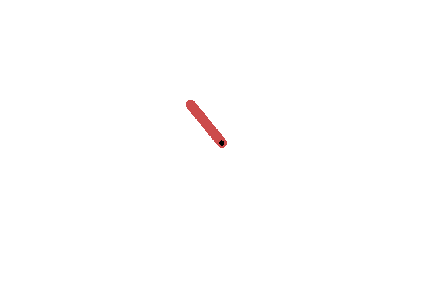
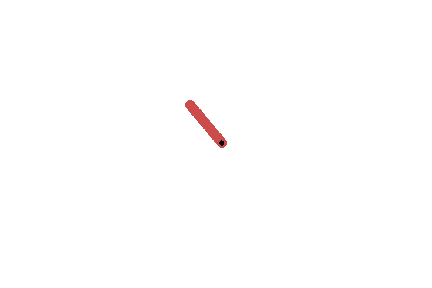
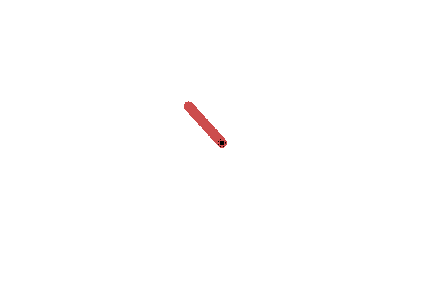
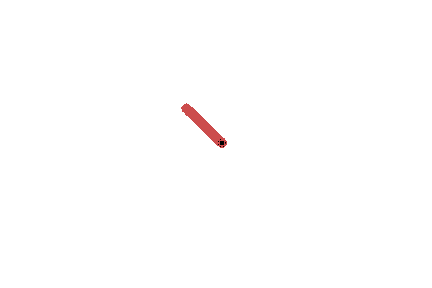
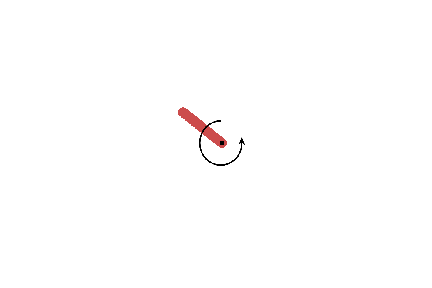
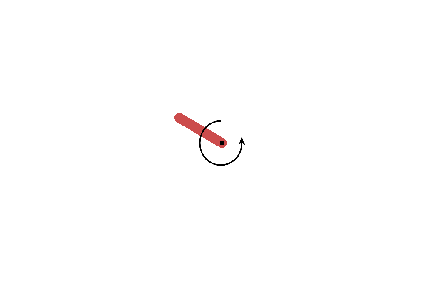
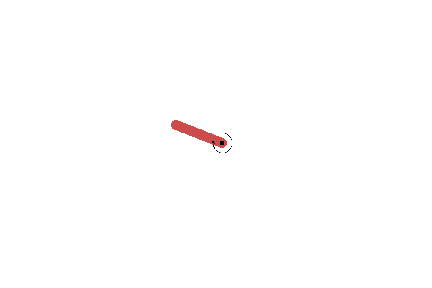
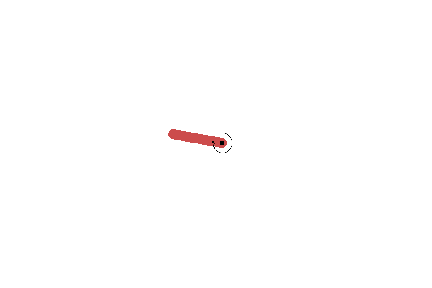
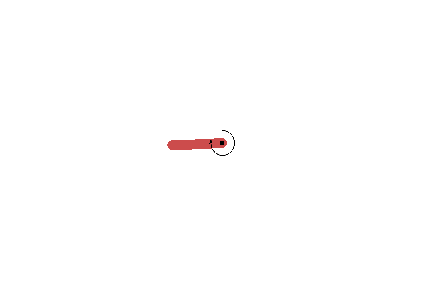
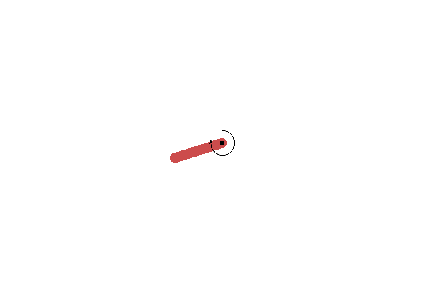
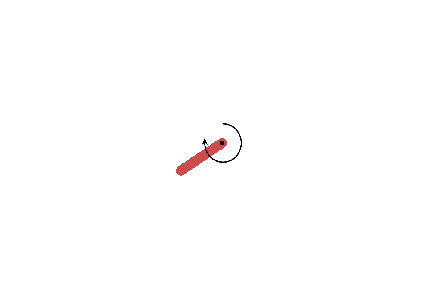
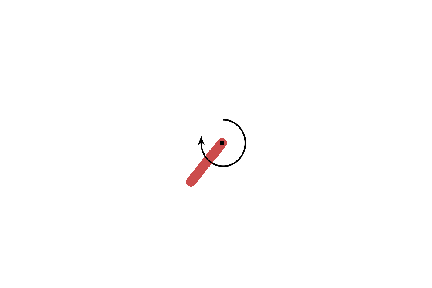
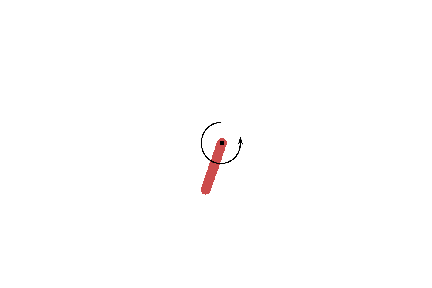
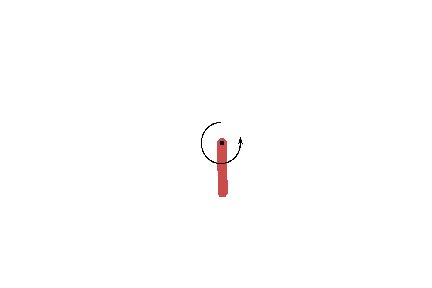
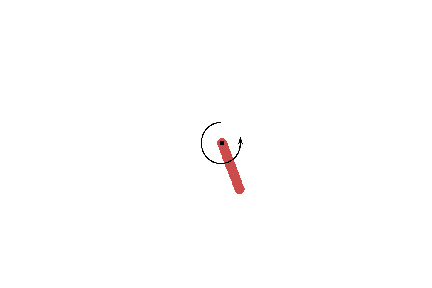
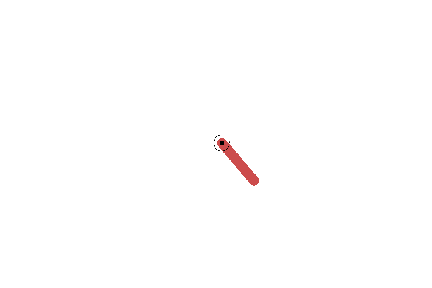
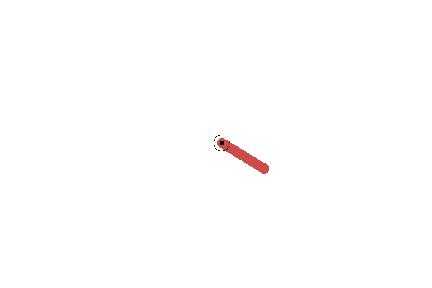
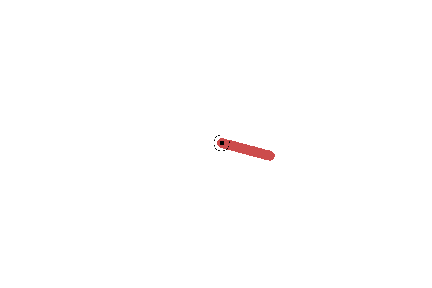
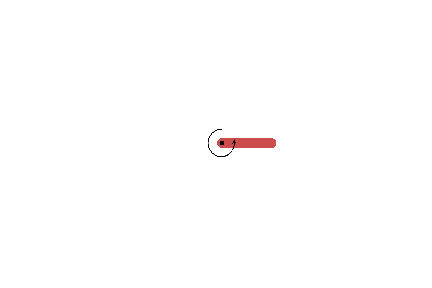
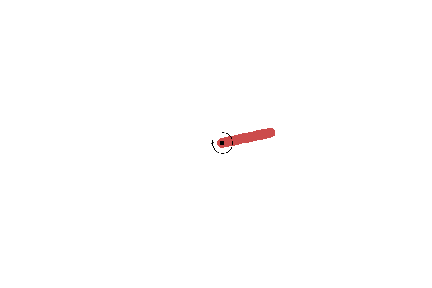
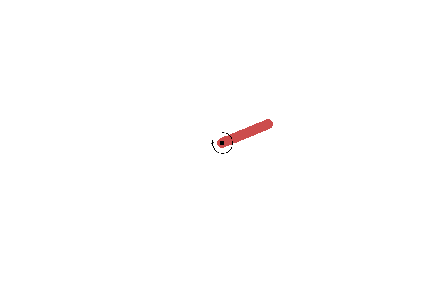
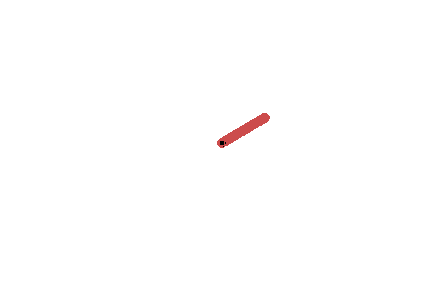
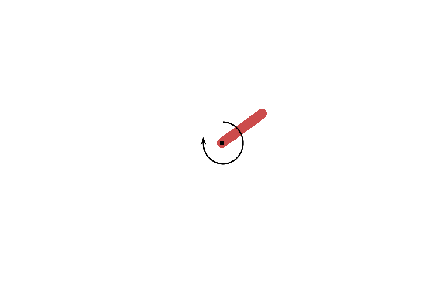
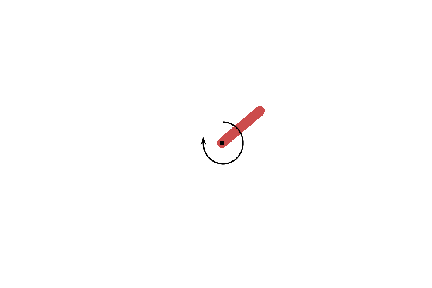

In [10]:
train(env,num_trials=num_trials,render=True)

## References

1. [Reinforcement Learning w/ Keras + OpenAI: Actor-Critic Models](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69)
2. [Actor Critic Algorithms](https://www.youtube.com/watch?v=w_3mmm0P0j8&ab_channel=SirajRaval)
3. [Pendulum-v0](https://gym.openai.com/envs/Pendulum-v0/)